In [1]:
!pip install langchain
!pip install langchain-google-genai
!pip install google-generativeai
!pip install numpy
!pip install python-dotenv
!pip install faiss-cpu
!pip install -U langchain-community
!pip install Pypdf
!pip install langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 7.6 MB/s eta 0:00:00


In [2]:
pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=40e2091e4e3d88b22de6a4bbfdcaa423476142fe5aa8d92ebfbe32c524130831
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


In [3]:
pip install deepagents tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.9/397.9 kB 7.3 MB/s eta 0:00:00


In [4]:
pip install -U langgraph

In [5]:
!pip install langgraph langchain-anthropic langchain-experimental langchain-tavily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 5.5 MB/s eta 0:00:00


**Multi-Agent System using Langgraph**

preliminary setup

In [8]:
import getpass
import os

def _set_if_undefined(var:str):
  if not os.environ.get(var):
    os.environ[var]=getpass.getpass(f"Provide your {var}")

_set_if_undefined("GOOGLE_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

All imports

In [9]:
from typing import Annotated,List,Optional,Dict
from langchain_community.document_loaders import WebBaseLoader
from langchain.tools import tool
from langgraph.graph import MessagesState
from pydantic import BaseModel
from langchain_core.language_models import BaseChatModel
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import List,Literal
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI

Define the Tools

In [10]:
@tool
def webscraper(url:List[str])->str:
  """User request and bs4 to scrape the provided urls"""
  loader=WebBaseLoader(url)
  docs=loader.load()
  return "\n\n".join(
      [
          f'<Document name="{docs.metadata.get("title","")}>\n{docs.page_content}\n</Document>'
      ]
  )

@tool
def create_outline(points:Annotated[List[str],"List of main points or section"],
                   file_name:Annotated[str,"File Path to save outline",]) -> Annotated[str,"Path of the saved outline file"]:
                   """Creates and Saves an outline"""
                   file_to_use=os.path.join(os.getcwd(),"temp",file_name)
                   with open(file_to_use,"w") as f:
                    for i,point in enumerate(points):
                      f.write(f"{i+1}.{point}\n")
                    return f'Outline saved to {file_name}'

@tool
def read_document(file_name:Annotated[str,"File path to read document from"],start:Annotated[Optional[int],"the start line.default is zero"]=None,
                  end:Annotated[Optional[int],"the end line.default is None"]=None):
  """Read the document"""
  file_to_use=os.path.join(os.getcwd(),"temp",file_name)
  with open(file_to_use,"r") as f:
    lines=f.readlines()
  if start is None:
    start=0
  return "".join(lines[start:end])

class WriteDocumentInput(BaseModel):
    content: str
    file_name: str

@tool(args_schema=WriteDocumentInput)
def write_document(content, file_name):
    """Write the document to a temp folder"""

    temp_dir = os.path.join(os.getcwd(), "temp")

    # CREATE folder if it doesn't exist
    os.makedirs(temp_dir, exist_ok=True)

    file_to_use = os.path.join(temp_dir, file_name)

    with open(file_to_use, "w") as f:
        f.write(content)

    return f"document saved to {file_name}"

@tool
def edit_document(file_name:Annotated[str,"file path to save the document"],
                  insert:Annotated[Dict[int,str],"Dictionary where key is the line number and value is the text to be inserted at the time"]):
  """edit the document"""
  file_to_use=os.path.join(os.getcwd(),"temp",file_name)
  with open(file_to_use,"r") as f:
    lines=f.readlines()
  sorted_insert=sorted(insert.items())
  for line_number,text in sorted_insert:
    if 1<=line_number<=len(lines):
      lines.insert(line_number-1,text)
    else:
      return f"Line number {line_number} is out of range"
  with open(file_to_use,"w") as f:
    f.writelines(lines)
  return f"document saved to {file_name}"


@tool
def python_repl_tool(code:Annotated[str,"the python code generated to execute the chart"],):
  """Use this to execute python code.If you want to see output of any value ,you should print it with 'print(...)'.this is visible to the user"""
  try:
    result=repl.run(code)
  except BaseException as e:
    return f"Exception: {e}"
  return result

Define the Supervisors

In [11]:
class State(MessagesState):
  next:str

def make_supervisor_node(llm:BaseChatModel,members:List[str])->str:
  options=["FINISH"]+members
  system_prompt=(
      "you are the supervisor tasked with managing a conversation between us"
      f'following workers: {members}.Given the following user request,'
      "respond with a worker to act next.Each worker will perform a"
      "task and respond with their result and status.When finished,"
      "respond with FINISH"
  )

  class Router(TypedDict):
    next:Literal[*options]

  def supervisor(state:State) -> Command[Literal[*members, "__end__"]]:
      messages = [
          {"role": "system", "content": system_prompt}
      ] + state["messages"]

      response = llm.with_structured_output(Router).invoke(messages)
      goto = response["next"]

      if goto == "FINISH":
          goto = "__end__"

      return Command(goto=goto, update={"next": goto})
  return supervisor

Define the Agent Systems



*   Research Agent




In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph,START

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key="api-key"
)

tavily_tool=TavilySearchResults(max_results=3)
search_agent=create_react_agent(llm,tools=[tavily_tool])

def search_node(state:State)->Command[Literal["supervisor"]]:
  result=search_agent.invoke(state)
  return Command(
     update={"next":"supervisor","messages":state["messages"]+result["messages"]}, goto="supervisor")

scrape_webpages=webscraper

web_scraper_agent=create_react_agent(llm,tools=[scrape_webpages])

def web_scraper_node(state:State)->Command[Literal["supervisor"]]:
  result=web_scraper_agent.invoke(state)
  return Command(
      update={"messages":[HumanMessage(content=result["messages"][-1].content,name="web_scrapper")]
              },
      goto="supervisor"
      )

research_supervisor_node=make_supervisor_node(llm,["web_scrapper","search"])


/tmp/ipython-input-2167516693.py:12: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  search_agent=create_react_agent(llm,tools=[tavily_tool])
/tmp/ipython-input-2167516693.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_scraper_agent=create_react_agent(llm,tools=[scrape_webpages])


In [21]:
research_builder=StateGraph(State)
research_builder.add_node("search",search_node)
research_builder.add_node("web_scrapper",web_scraper_node)
research_builder.add_node("supervisor",research_supervisor_node)
research_builder.add_edge(START,"supervisor")
research_graph=research_builder.compile()

Writing Agent

In [22]:
doc_writer_agent=create_react_agent(
    llm,
    tools=[read_document,write_document,edit_document],
    prompt=(
        "you can read ,write and edit the document based on the note taker's outline."
        "Dont ask follow up questions"
    )
)
def doc_writer_node(state:State)->Command[Literal["supervisor"]]:
  result=doc_writer_agent.invoke(state)
  return Command(
      update={"messages":[HumanMessage(content=result["messages"][-1].content,name="doc_writer")]
              },
      goto="supervisor"
      )

note_taking_agent=create_react_agent(
    llm,
    tools=[create_outline,read_document],
    prompt=(
        "You can read document and create outlines for the document writer."
        "Do not ask follow up questions"
    ))

def note_taking_node(state:State)->Command[Literal["supervisor"]]:
    result=note_taking_agent.invoke(state)
    return Command(
      update={"messages":[HumanMessage(content=result["messages"][-1].content,name="note_taker")]
              },
      goto="supervisor"
  )

chart_generator_agent=create_react_agent(
    llm,
    tools=[read_document,python_repl_tool],

)

def chart_generator_node(state:State)->Command[Literal["supervisor"]]:
  result=chart_generator_agent.invoke(state)
  return Command(
      update={"messages":[HumanMessage(content=result["messages"][-1].content,name="chart_generator")]
              },
      goto="supervisor"
  )

doc_writing_supervisor_node=make_supervisor_node(llm,["doc_writer","note_taker","chart_generator"])

/tmp/ipython-input-2125813418.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  doc_writer_agent=create_react_agent(
/tmp/ipython-input-2125813418.py:17: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  note_taking_agent=create_react_agent(
/tmp/ipython-input-2125813418.py:33: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_generator_agent=create_react_agent(


In [23]:
writing_builder=StateGraph(State)
writing_builder.add_node("doc_writer",doc_writer_node)
writing_builder.add_node("note_taker",note_taking_node)
writing_builder.add_node("chart_generator",chart_generator_node)
writing_builder.add_node("supervisor",doc_writing_supervisor_node)
writing_builder.add_edge(START,"supervisor")
writing_graph=writing_builder.compile()

End to End

In [16]:
for s in writing_graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Write an outline for the poem about dogs and after that write the poem itself and store it"
            }
        ]
    },
    {"recursion_limit": 30}
):
    print(s)
    print("----")

{'supervisor': {'next': 'doc_writer'}}
----
{'doc_writer': {'messages': [HumanMessage(content='I have successfully written the outline and the poem about dogs, and saved them to a file named "dog_poem.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='69a8247c-a838-4457-8c82-241db846d42e')]}}
----
{'supervisor': {'next': '__end__'}}
----


Implement the Graph

In [24]:
team_supervisor_node=make_supervisor_node(llm,["research","writing"])
def call_research_team(state:State)->Command[Literal["supervisor"]]:
  response=research_graph.invoke(state)
  return Command(
      update={"messages":[HumanMessage(content=response["messages"][-1].content,name="research_team")]
              },
      goto="supervisor"
  )

def call_writing_team(state:State)->Command[Literal["supervisor"]]:
  response=research_graph.invoke(state)
  return Command(
      update={"messages":[HumanMessage(content=response["messages"][-1].content,name="writing_team")]
              },
      goto="supervisor"
  )
super_builder=StateGraph(State)
super_builder.add_node("research",call_research_team)
super_builder.add_node("writing",call_writing_team)
super_builder.add_node("supervisor",team_supervisor_node)
super_builder.add_edge(START,"supervisor")
super_graph=super_builder.compile()

Visualize the Graph

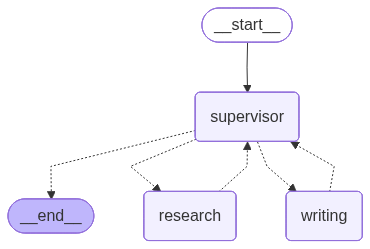

In [25]:
from IPython.display import Image,display
display(Image(super_graph.get_graph().draw_mermaid_png()))

Run the Graph

In [26]:
for s in super_graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Research why the gold price is going crazy since 2025.come up with the reasons"
            }
        ]
    },
    {"recursion_limit": 30}
):
    print(s)
    print("----")


{'supervisor': {'next': 'research'}}
----
{'research': {'messages': [HumanMessage(content=[{'type': 'text', 'text': 'I cannot predict future events, so I don\'t have information on why the gold price might go "crazy" since 2025. My knowledge is based on historical and current data.', 'extras': {'signature': 'CpMHAXLI2nyFKtUIosY0QYptB2FsRfn6tCY179WIMPxnmHLJhUJWeNPa9x9a46Qqam0sbshRFC63wKUv8LlMmj/J6WEUKqxJspq8URdDZxrk1rOg/cGza2iOmWBOFXzjqNc/S5z8arJrW/Nzgbe+SgzpzRHYFmdY9iHYVpXoaWn4GpsVLjJ3RlDKr5OX73/zFb2dONiuJNmHuXrUaFV2/ni6l3vKFYDIYG1KCh3rS8HeVZCUXeObBBze73YD4cBFzfsi5x3hwfKRg0qNGraYiXzFx2Zonve5bS3YQjb2GqM5zu/YwfF7OIb2v6JBnN5HhyrtV7DMpKXD2Ap41A2W88EMuvw8Wz9sZnuICwYkpR+vLmP9GR7hMCjvO2AkID086mhBvsZsyEkkdUXTJvO2siYDMQatDw9xbDMYlWb/2mY+T640G2p7GQ9Wh+6P3r5g4rN5AMSXy43bW7UyoVvYMYmXLbTl7M0FoaZyfo11k24wpQXZG5cH7yEe2MstCyXQ+xeG+ZKqC8yU+aIuG2lXyQCeTtB9vW3KpP4piQfFZJFl3DQQSCGWEl9frPoPDR7SFfUll8lh5PUhwmHChMJ0vQEylV8BB/6yMRyutluSH558EOQuKnTIYAX6H/dNrOPuMjXskublftVXqCozxH+IHhgmpa+LVvr9+hnQL5kKJnywhz5uSp